# Activity Detection's Results Analysis

**<span style="font-size:15px;">Copyright (c) 2024 Sepideh Nikookar</span>**

In [46]:
import os
import pickle 
import numpy as np
import pandas as pd
from sys import path
import seaborn as sns
from os import listdir
from numpy import mean
import statsmodels.api as sm
import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from keras.models import load_model
import statsmodels.formula.api as smf
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [31]:
def conf_matrix(path, num_classes):

    # Load the saved npz file
    loaded_data = np.load(path)
    
    
    # Optionally, you can access the list of confusion matrices directly
    conf_matrix_test_list = [loaded_data[key] for key in loaded_data.files]
    
    cumulative_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for conf_matrix in conf_matrix_test_list:
        cumulative_conf_matrix += conf_matrix

    row_sums = cumulative_conf_matrix.sum(axis=1, keepdims=True)
    normalized_confusion_matrix = cumulative_conf_matrix / row_sums.astype(float)
    
    return np.round(normalized_confusion_matrix, decimals=2)

cm = conf_matrix('./5.0s__Models_2.0/confusion_matrices.npz', 5)    

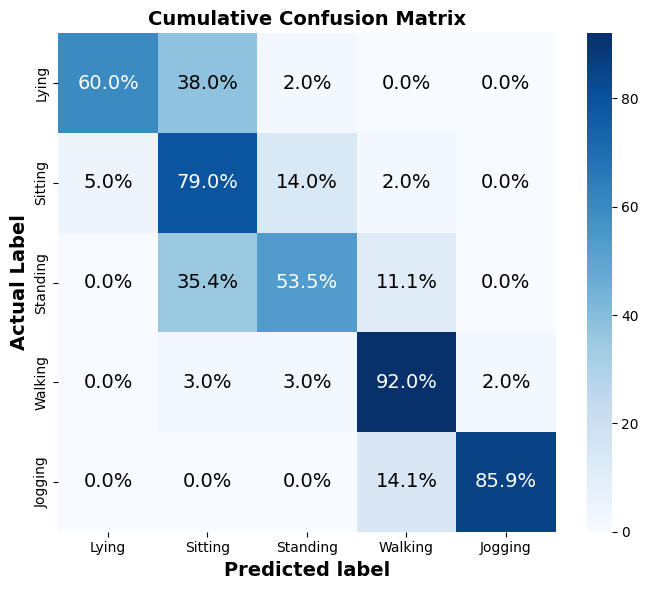

In [33]:
def plot_cm(cm):
    labels = ['Lying', 'Sitting', 'Standing', 'Walking', 'Jogging']
    
    # Convert confusion matrix values to percentages
    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

    # Create the heatmap
    plt.figure(figsize=(7, 6))
    cmap = plt.get_cmap('Blues')
    norm = Normalize(vmin=cm_percent.min(), vmax=cm_percent.max())
    ax = sns.heatmap(cm_percent, cmap=cmap, cbar=True,
                     xticklabels=labels, yticklabels=labels, 
                     annot=False)  # Disable default annotations

    # Add custom annotations with percentage formatting
    for i in range(cm_percent.shape[0]):
        for j in range(cm_percent.shape[1]):
            value = cm_percent[i, j]
            text_color = 'black' if value < 50 else 'white'  # Choose text color based on value
            ax.text(j + 0.5, i + 0.5, f'{value:.1f}%', 
                    ha='center', va='center', color=text_color, 
                    fontsize=14)

    # Customize labels and title
    plt.xlabel('Predicted label', fontsize=14, fontweight='bold')
    plt.ylabel('Actual Label', fontsize=14, fontweight='bold')
    plt.title('Cumulative Confusion Matrix', fontsize=14, fontweight='bold')


    plt.tight_layout()
    plt.savefig('Posture_Confusion_Matrix_5s_50Hz.png', transparent = True)
    plt.show()

plot_cm(cm)

In [35]:
dir = './5.0s__Models_2.0'

acc = np.load(f'{dir}/Accuracy.npy')
pre = np.load(f'{dir}/Precision.npy')
recall = np.load(f'{dir}/Recall.npy')
f1 = np.load(f'{dir}/F1.npy')

In [36]:
data = {
    'Fold': [i for i in range(1, 24)],
    'Accuracy': acc,
    'Recall': recall,
    'Precision': pre,
    'F1_Score': f1
}

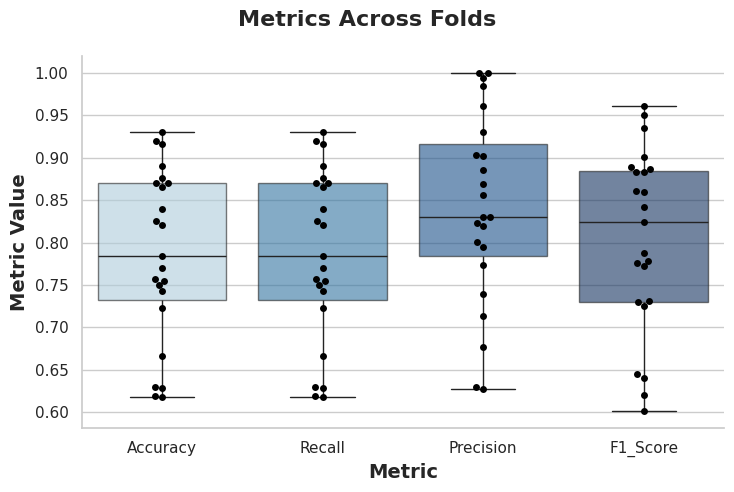

In [37]:
# Create a DataFrame from the data
df = pd.DataFrame(data)

# Melt the DataFrame to have a 'Metric' column
df_melted = pd.melt(df, id_vars=['Fold'], var_name='Metric', value_name='Value')

# Define more distinct shades of blue for each metric
custom_palette = {
    'Accuracy': '#a6cee3',  # Lighter blue
    'Recall': '#1f78b4',    # Medium blue
    'Precision': '#08519c', # Darker blue
    'F1_Score': '#08306b'   # Very dark blue
}

# Create a box plot with different shades of blue for each metric
sns.set(style="whitegrid")
g = sns.catplot(
    x='Metric', y='Value', kind='box', data=df_melted, aspect=1.5,
    palette=custom_palette, hue='Metric', legend=False,
    boxprops=dict(alpha=0.6), flierprops=dict(alpha=0)  # Set alpha for box transparency and remove fliers
)

# Add actual points using swarm plot with increased transparency
sns.swarmplot(x='Metric', y='Value', data=df_melted, dodge=True, color='black')

# Customize the plot
g.fig.suptitle('Metrics Across Folds', fontweight='bold', fontsize=16)
g.set_axis_labels('Metric', 'Metric Value', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('Posture_Metrics_BoxPlot.png')

# Show the plot
plt.show()

In [38]:
def metrics(type):
    dict = {}
    for fs in [5, 10, 25, 50]:
        window_dict = {}
        for window in [1.0, 2.0, 4.0, 5.0, 8.0, 12.0]:
            if fs == 50 and window == 5.0:
                path = f"{window}s__Models_2.0"
            else:
                path = f"{window}s_{fs}Hz__Models"
            
            window_dict[int(window)] = int(round(mean(np.load(f'{path}/{type}.npy')), 2) * 100)
        
        dict[fs] = window_dict

    return dict

In [39]:
accuracy = metrics('Accuracy')
precision = metrics('Precision')
recall = metrics('Recall')
f1 = metrics('F1')

In [ ]:
def plot_heatmap(ax, data, metric_type):
    sampling_frequencies = sorted(data.keys())
    window_sizes = sorted(data[sampling_frequencies[0]].keys())

    # Create a 2D array for the percentage values
    percentage_values = np.array([[data[sf][ws] for ws in window_sizes] for sf in sampling_frequencies])

    # Plotting the heatmap
    cmap = plt.get_cmap('Blues')
    im = ax.imshow(percentage_values, cmap=cmap)

    # Set labels
    ax.set_yticks(np.arange(len(sampling_frequencies)))
    ax.set_xticks(np.arange(len(window_sizes)))
    ax.set_yticklabels(sampling_frequencies)
    ax.set_xticklabels(window_sizes)
    ax.set_ylabel('Sampling Frequency (Hz)', fontsize=10, fontweight='bold')
    ax.set_xlabel('Window Size (Seconds)', fontsize=10, fontweight='bold')

    # Invert the y-axis
    ax.invert_yaxis()

    # Get the colors of the cells
    norm = plt.Normalize(percentage_values.min(), percentage_values.max())
    colors = cmap(norm(percentage_values))

    # Add values inside the heatmap cells with adjusted positioning
    for i in range(len(sampling_frequencies)):
        for j in range(len(window_sizes)):
            value = percentage_values[i, j]
            color = colors[i, j]  # Get the color of the cell
            # Decide text color based on the cell color
            text_color = 'white' if np.mean(color[:3]) < 0.5 else 'black'
            ax.text(j, i, f'{value}%', ha='center', va='center', color=text_color, fontsize=14)

    ax.set_title(f'{metric_type}', fontsize=14, fontweight='bold')

    return im

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot each heatmap and collect the mappable objects (images)
ims = []
ims.append(plot_heatmap(axs[0, 0], accuracy, 'Accuracy'))
ims.append(plot_heatmap(axs[0, 1], recall, 'Recall'))
ims.append(plot_heatmap(axs[1, 0], f1, 'F1 Score'))
ims.append(plot_heatmap(axs[1, 1], precision, 'Precision'))


# Create a common colorbar for all heatmaps (vertical)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust the parameters as needed
cbar = fig.colorbar(ims[0], cax=cbar_ax, orientation='vertical')
cbar.set_label('Percentage', fontsize=14, fontweight='bold')

fig.subplots_adjust(right=0.9)  # Adjust the right parameter to avoid overlap with the colorbar
plt.savefig('Metrics_vs_inputSize_vs_SamplingFrequency.png', transparent=True)
plt.show()

In [40]:
def Sampling_Frequencies(type):
    dict = {}
    for n in [5, 10, 25]:
        path = f"5s_{n}Hz__Models"
        dict[n] = int(round(mean(np.load(f'{path}/{type}.npy')), 2) * 100)

    return dict

In [41]:
def get_data(lst, x, type):

    result = {}
    
    for i, metric in enumerate(['Accuracy', 'Recall', 'Precision', 'F1']):
        dict = {}
        for n in lst:
            if n == x:
                path = "5.0s__Models_2.0"
            else:
                if type == 'Input_Size':
                    path = f"{n}s_50Hz__Models"
                elif type == 'Sampling_Rate':
                    path = f"5.0s_{n}Hz__Models"
                elif type == 'Cutoff':
                    path = f"5.0s__Models_{n}"
                    
            dict[n] = [int(round(i, 2) * 100) for i in np.load(f'{path}/{metric}.npy')]

        result[metric] = dict


    return result

In [42]:
input_size_dict = get_data([1.0, 2.0, 5.0, 4.0, 8.0, 12.0], 5.0, 'Input_Size')
sampling_rate_dict = get_data([5, 10, 25, 50], 50, 'Sampling_Rate')
cutoff_dict = get_data([2.0, 5.0, 10.0, 15.0, 20.0], 2.0, 'Cutoff')

In [ ]:
def flatten_data(data, type):

    # Flatten the nested dictionary
    flat_data = []
    for metric, sizes_dict in data.items():
        for size, values_list in sizes_dict.items():
            for subject, value in enumerate(values_list, start=1):
                flat_data.append({'Subject': subject, 'Metric': metric, f'{type}_Value': size, 'Metric_Value': value})
    
    # Create DataFrame from flattened data
    df = pd.DataFrame(flat_data)

    return df

input_size_df = flatten_data(input_size_dict, 'Input_Size')
sampling_rate_df = flatten_data(sampling_rate_dict, 'Sampling_Rate')
cutoff_df = flatten_data(cutoff_dict, 'Cutoff')

In [43]:
# Define the parameters and metrics

values = {'Window_Size': [1.0, 2.0, 4.0, 5.0, 8.0, 12.0],
          'Sampling_Rate': [5, 10, 25, 50]}

metrics = ['Accuracy', 'Recall', 'Precision', 'F1']

# Initialize an empty list to store the data
data = []

# Iterate over each combination of input_size and sampling_rate
for input_size in values['Window_Size']:
    for sampling_rate in values['Sampling_Rate']:
        # Iterate over each metric
        for metric in metrics:
            # Define the path to the numpy file
            
            if input_size == 5.0 and sampling_rate == 50:
                file_path = "5.0s__Models_2.0"
            else:
                file_path = f"./{input_size}s_{sampling_rate}Hz__Models"
            

            # Read the numpy file
            metric_values = np.load(f'{file_path}/{metric}.npy')
            # Extract subject numbers (assuming subject numbers are 1-indexed)
            subjects = range(1, len(metric_values) + 1)
            # Append the data to the list
            for subject, value in zip(subjects, metric_values):
                data.append({'Subject': subject,
                             'Window_Size': input_size,
                             'Sampling_Rate': sampling_rate,
                             'Metric': metric,
                             'Value': int(round(value, 2) * 100)})

# Create a dataframe from the list of dictionaries
df = pd.DataFrame(data)


# Convert 'Input_Size' and 'Sampling_Rate' to categorical values
df['Window_Size'] = pd.Categorical(df['Window_Size'], categories=values['Window_Size'])
df['Sampling_Rate'] = pd.Categorical(df['Sampling_Rate'], categories=values['Sampling_Rate'])

# Display the dataframe
df


,Subject,Window_Size,Sampling_Rate,Metric,Value
0,1,1.0,5,Accuracy,42
1,2,1.0,5,Accuracy,63
2,3,1.0,5,Accuracy,48
3,4,1.0,5,Accuracy,4
4,5,1.0,5,Accuracy,44
...,...,...,...,...,...
2203,19,12.0,50,F1,94
2204,20,12.0,50,F1,83
2205,21,12.0,50,F1,89
2206,22,12.0,50,F1,64


In [44]:
# Define the model formula with 'Input_Size' and 'Sampling_Rate' reference categories
formula = "Value ~ C(Window_Size, Treatment(12.0)) + C(Sampling_Rate, Treatment(50)) + C(Metric, Treatment('F1'))"

# Fit the mixed-effects model
model = smf.mixedlm(formula, df, groups=df['Subject'])
result = model.fit(method=["lbfgs"])

# Print the summary of the model
print(result.summary())


                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           Value     
No. Observations:           2208              Method:                       REML      
No. Groups:                 23                Scale:                        64.9441   
Min. group size:            96                Log-Likelihood:               -7785.0139
Max. group size:            96                Converged:                    Yes       
Mean group size:            96.0                                                      
--------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------------
Intercept                                83.005    1.849  44.899 0.000  79.381  86.628
C(Window_Size, Treatment(12.0))[T.1.0]  -12.389    0.594 -20.853 0.0

In [8]:
# 1. Variance Components
variance_components = result.cov_re
print("Variance Components:", variance_components)
print()

# 3. Random Effects Structure
random_effects_structure = result.random_effects
# for i,j in random_effects_structure.items():
#     print("{} : {}".format(i, j))
print("Random_Effects_Structure", random_effects_structure)

Variance Components:            Group
Group  70.490059

Random_Effects_Structure {1: Group   -13.160383
dtype: float64, 2: Group    11.25117
dtype: float64, 3: Group    0.149382
dtype: float64, 4: Group    4.988358
dtype: float64, 5: Group   -1.697477
dtype: float64, 6: Group   -15.646936
dtype: float64, 7: Group   -4.895948
dtype: float64, 8: Group    8.62017
dtype: float64, 9: Group    2.161323
dtype: float64, 10: Group   -10.519066
dtype: float64, 11: Group   -9.724607
dtype: float64, 12: Group   -1.831607
dtype: float64, 13: Group    3.801829
dtype: float64, 14: Group    2.739111
dtype: float64, 15: Group   -3.740371
dtype: float64, 16: Group    8.826523
dtype: float64, 17: Group    9.971782
dtype: float64, 18: Group    12.035311
dtype: float64, 19: Group    4.93677
dtype: float64, 20: Group    1.243052
dtype: float64, 21: Group    7.39237
dtype: float64, 22: Group   -14.408818
dtype: float64, 23: Group   -2.491936
dtype: float64}


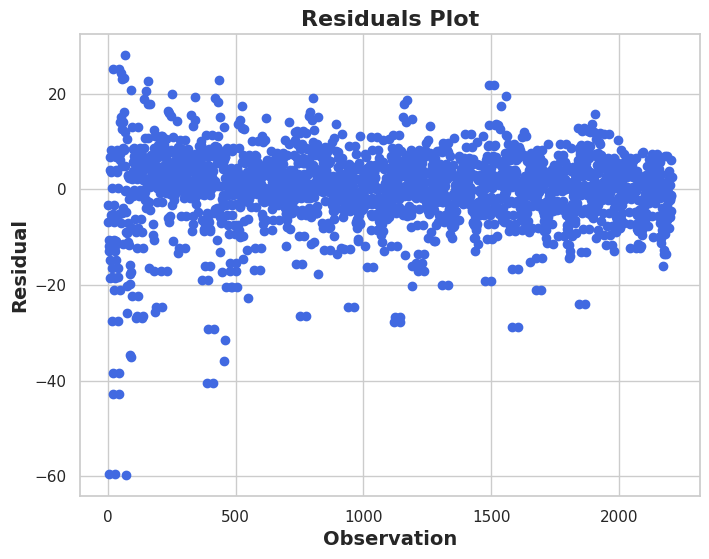

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(result.resid, 'o', color='royalblue')
plt.title('Residuals Plot', fontsize=16, fontweight='bold')
plt.xlabel('Observation', fontsize=14, fontweight='bold')
plt.ylabel('Residual', fontsize=14, fontweight='bold')
plt.savefig('Residuals_Plot.png', transparent=True)
plt.show()